In [1]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
import pandas as pd
import GMC_GC_util

#R0 = 8.2 ± 0.1 kpc, z0 = 25 ± 5 pc, and the solar velocity vector {vR, vφ, vz} = {−10 ± 1, 248 ± #3, 7 ± 1} km/s

ro=8.
vo=220.

Populating the interactive namespace from numpy and matplotlib


# The catalog below is a combination of the catalog of globular clusters from Helmi et al https://arxiv.org/abs/1804.09381 and Vasiliev's paper https://arxiv.org/abs/1807.09775.

In [2]:
#Helmi et al's values take precedence, wherever they are missing, I have used the values from Vasiliev.
#The entire distance column is from Vasiliev's paper. ESO 456-78 (BH 261) and Terzan 10's Vlos were missing, so
#I have removed them.

#mass of GC = Nmember as of now!!

dat=pd.io.parsers.read_csv("globular_clusters/catalogue_Helmi_combined.txt",sep="\t",header=0,
                           usecols=(1,2,3,4,5,6,7,9),dtype=float,skiprows=[1])

#print (dat.index)
#print (dat.values)
print (dat.columns)

print (dat)
print (len(dat))

Index(['RA', 'DEC', 'D', 'Vlos', 'PMRA', 'PMDEC', 'rmaxdegr', 'Nmember'], dtype='object')
           RA      DEC      D    Vlos    PMRA    PMDEC  rmaxdegr  Nmember
0    253.0440 -47.0580   10.8    5.00 -5.0160  -0.1920      0.03     49.0
1    292.1840 -30.3560   28.6  122.50 -2.3840  -1.5190      0.07    235.0
2    242.7650 -55.3180    8.0    8.00 -3.8430  -7.0400      0.05    327.0
3    262.7720 -29.9820    8.2   40.10  2.4630 -10.1900      0.03    119.0
4    174.0670 -10.8770  145.0  148.20 -0.0600  -0.0980      0.05     10.0
5     58.7600 -49.6150  123.3  116.00  0.3370  -0.3850      0.04     37.0
6    140.2380 -77.2820    8.1    4.80 -2.6940   7.1150      0.07    338.0
7     66.1850 -21.1870   90.1  -23.60  0.4910  -0.3720      0.07     31.0
8    234.7810 -50.0530   18.9   -6.00 -3.9890  -3.0670      0.03    165.0
9    272.2750 -46.4230   21.4   93.20 -0.5570  -2.7240      0.03     57.0
10   249.8560 -28.3990    8.3   16.40 -1.5360  -6.4280      0.03    128.0
11   270.4550 -27.8260

### setup the orbits of the globular clusters

10.0 68783.0


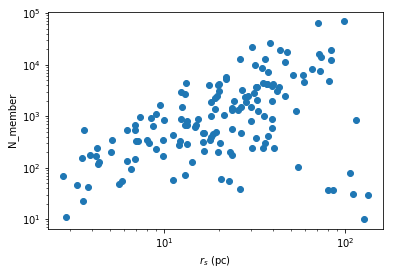

In [3]:
coord= []

t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)

for ii in range(len(dat)):
    coord.append(list(dat[['RA','DEC','D','PMRA','PMDEC','Vlos']].values[ii]))

    
#plot r vs M
rs=np.radians(dat['rmaxdegr'].values)*(dat['D'].values)
M=dat['Nmember'].values

print (min(M),max(M))

plt.figure()
plt.scatter(rs*1000.,M)
plt.xlabel(r'$r_{s}$ (pc)')
plt.ylabel(r'N_member')
plt.xscale('log')
plt.yscale('log')
plt.show()
    
 

## Integrate the GCs orbit 5 Gyrs back

In [4]:
orbits= []

N=len(dat)

for ii in range(N):
    orbits.append(Orbit(coord[ii],radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25]).flip()) # flip flips the velocities for backwards integration
    orbits[ii].integrate(t_age,MWPotential2014)


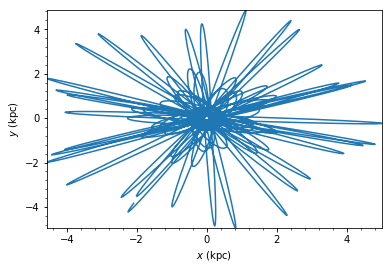

In [5]:
orbits[0].plot(d1='x',d2='y')

### Load streampeppered object

In [6]:
import pal5_util
sdf_smooth= pal5_util.setup_pal5model()

#assume hernquist
with open('../GMC/pkl_files/pal5pepper_1024sampling_MW2014.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

### compute minimum separation at each timpact for every GC

In [7]:
timpact=sdf_pepper._timpact

#for each MC store min sep and apar of closest approach at each timpact
min_sep_matrix=np.empty([len(orbits),len(timpact)])
apar_matrix=np.empty([len(orbits),len(timpact)])


for kk in range(len(timpact)):
    
    apar=[]
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    
    a= sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedObsTrackXY
    apar_all=sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedThetasTrack
      
            
    #at each timpact compute apar_max
    apar_max=sdf_smooth.length(tdisrupt=sdf_pepper._tdisrupt-timpact[kk])*sdf_pepper._length_factor
    
    #considering the stream until apar_max, store xyzvxvyvz 
    for ii in range(len(apar_all)):
        if apar_all[ii] <= apar_max :
            apar.append(apar_all[ii])
            x.append(a[:,0][ii])
            y.append(a[:,1][ii])
            z.append(a[:,2][ii])
            vx.append(a[:,3][ii])
            vy.append(a[:,4][ii])
            vz.append(a[:,5][ii])
            
    x_stream=np.array(x)
    y_stream=np.array(y)
    z_stream=np.array(z)
    vx_stream=np.array(vx)
    vy_stream=np.array(vy)
    vz_stream=np.array(vz)
    apar=np.array(apar)
    
      
    #compute min_sep of each MC
    for jj in range(len(orbits)) :
        x_mc=orbits[jj].x(timpact[kk])
        y_mc=orbits[jj].y(timpact[kk])
        z_mc=orbits[jj].z(timpact[kk])
        
        min_sep,apar_min=GMC_GC_util.compute_min_separation(x_mc,y_mc,z_mc,apar,x_stream,y_stream,z_stream)
        
        min_sep_matrix[jj,kk]=min_sep
        apar_matrix[jj,kk]=apar_min
           


In [8]:
#from the constructed matrices of min_sep and min_apar, compute the min separation for each GC for all timpact
#and the corresponding apar_min, also compute velocity of the GC at that timpact

#impactb=np.empty(len(orbits))
#impact_angle=np.empty(len(orbits))
#vx_mc=np.empty(len(orbits))
#vy_mc=np.empty(len(orbits))
#vz_mc=np.empty(len(orbits))
#timpact_at_min=np.empty(len(orbits))

impactb=[]
impact_angle=[]
vx_mc=[]
vy_mc=[]
vz_mc=[]
timpact_at_min=[]
rs_mc=[]
M_mc=[]


c=0
for ii in range(len(orbits)):
    
    bmax=0.5/ro  #use a fixed distance of 500 pc
    
    if min(min_sep_matrix[ii]) <= bmax :
        c+=1
        
        min_timpact_ind=np.argmin(min_sep_matrix[ii])
        print (ii)
        impactb.append(min_sep_matrix[ii,min_timpact_ind])
        impact_angle.append(sdf_pepper._sigMeanSign*apar_matrix[ii,min_timpact_ind]) # _sigMeanSign = -/+ = trail/lead
        timpact_at_min.append(timpact[min_timpact_ind])
        rs_mc.append(rs[ii]/ro)
        M_mc.append(M[ii]/bovy_conversion.mass_in_msol(vo,ro))
        #flip velocities
        vx_mc.append(-orbits[ii].vx(timpact[min_timpact_ind]))
        vy_mc.append(-orbits[ii].vy(timpact[min_timpact_ind]))
        vz_mc.append(-orbits[ii].vz(timpact[min_timpact_ind]))

#combine vx,vy,vz to v
v_mc=np.c_[vx_mc,vy_mc,vz_mc]
print ("There were %i impacts"%c)

10
11
14
82
88
90
140
145
There were 8 impacts


0.0625 [0.04497948]


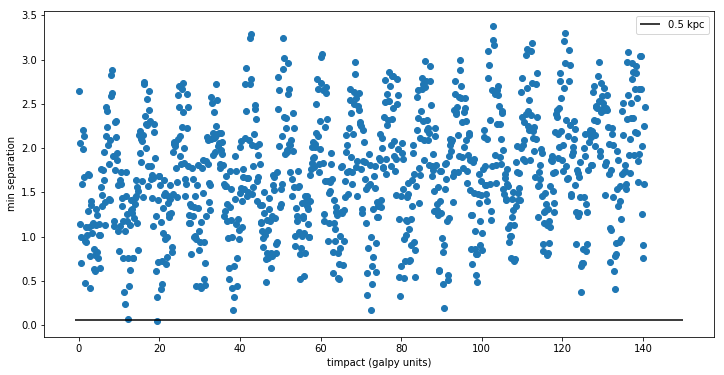

In [10]:
#for each MC plot min separation at all timpact

ind=140

aa=min_sep_matrix[ind]

print (0.5/ro,aa[aa<0.5/ro]) #print min_sep everytime it closer than 5r_s



plt.figure(figsize=(12,6))
plt.scatter(timpact,min_sep_matrix[ind])
plt.hlines(0.5/ro,-1.,150.,label=r'0.5 kpc')
plt.xlabel('timpact (galpy units)')
plt.ylabel('min separation')
plt.legend(loc='upper right')
#plt.savefig('min_separation_MC{}.pdf'.format(ind))
plt.show()

[46.645652406108134, 13.03334405464786, 89.8614774294142, 12.758957864023694, 45.41091454829939, 29.08493620616154, 19.48141953431575, 115.79097244339783]


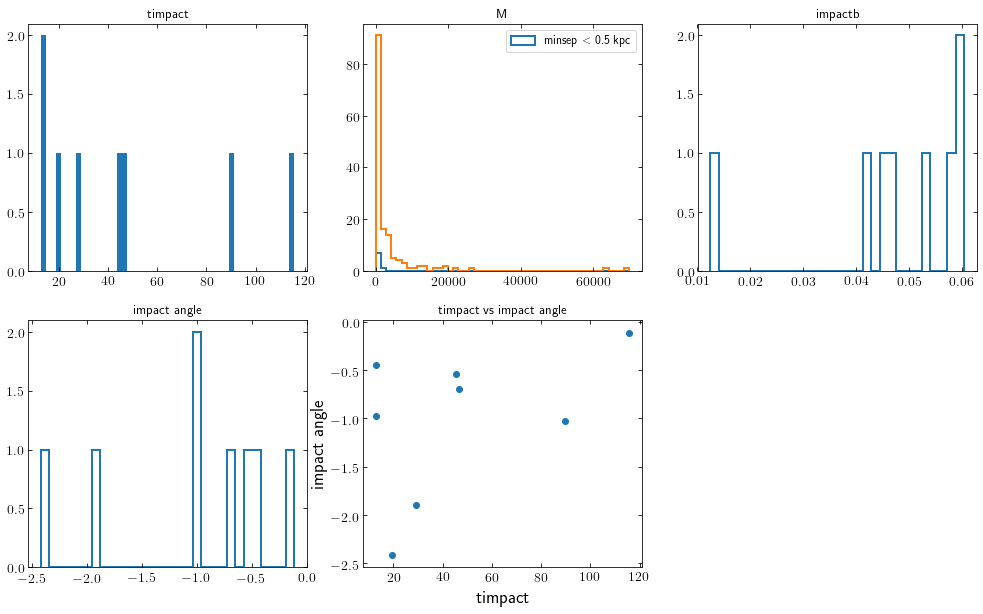

In [26]:
#a) histogram of timpact
#b) histogram of M (and maybe compare to the full histogram of M)
#c) histogram of impactb
#d) histogram of impact angle
#e) timpact vs. impact angle

#plot histogram of min separation vs timpact

dt=timpact[1]-timpact[0]
tbin_edges=[timpact[0] - 0.5*(dt) + i*dt for i in range(len(timpact)+1)] 

print (timpact_at_min)

plt.figure(figsize=(17,10))
plt.subplot(2,3,1)
plt.title('timpact')
plt.hist(timpact_at_min,bins=50)

plt.subplot(2,3,2)
mbins=np.linspace(9,70000,50)

plt.title('M')
plt.hist(np.array(M_mc)*bovy_conversion.mass_in_msol(vo,ro),bins=mbins,histtype='step',lw=2,label=r'minsep $<$ 0.5 kpc')
plt.hist(M,bins=mbins,histtype='step',lw=2)
plt.legend(loc='upper right')



plt.subplot(2,3,3)
plt.title('impactb')
plt.hist(impactb,bins=30,histtype='step',lw=2)





plt.subplot(2,3,4)
plt.title('impact angle')
plt.hist(impact_angle,bins=30,histtype='step',lw=2)




plt.subplot(2,3,5)
plt.title('timpact vs impact angle')
plt.scatter(timpact_at_min,impact_angle)
plt.xlabel('timpact')
plt.ylabel('impact angle')

#plt.savefig('plots/MC_impact_test_{}timpacts.pdf'.format(len(timpact)))

plt.show()






In [17]:
import streampepperdf

sdf_pepper.set_impacts(impactb=impactb,subhalovel=v_mc,impact_angle=impact_angle,timpact=timpact_at_min,rs=rs_mc,GM=M_mc)



In [18]:
apar=numpy.arange(0.,1.75,0.01)

dens_unp= [sdf_smooth._density_par(a) for a in apar]
omega_unp= [sdf_smooth.meanOmega(a,oned=True) for a in apar]
densOmega= numpy.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apar]).T

In [23]:
from scipy import ndimage, signal, interpolate
import simulate_streampepper

def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))


def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.0001,10.)
    xlim(1,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

def compute_Pk(ll,tdata):
    
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    #return 180./px/numpy.pi, py, py_err #if apars
    
    return (px,py)

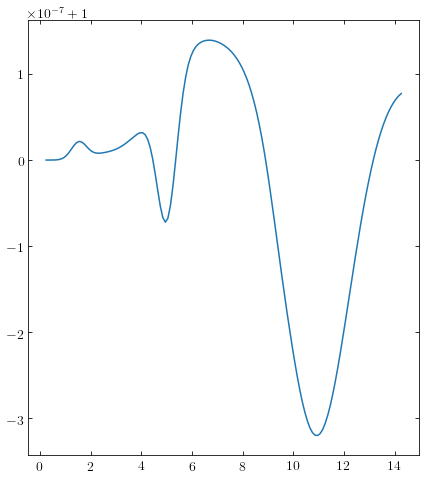

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide



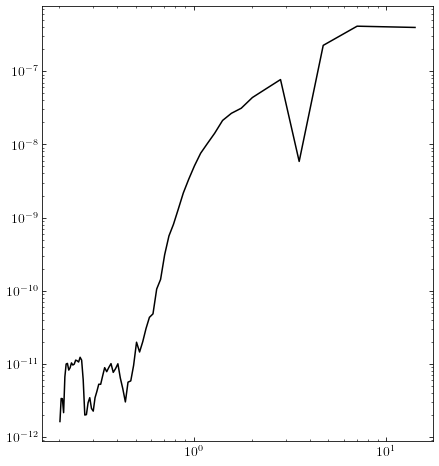

In [29]:
#convert to physical coordinates and plot power

ll,tdata= convert_dens_to_obs(apar,densOmega[0],dens_unp,densOmega[1],poly_deg=3)

plt.figure()
plt.plot(ll,tdata)
plt.show()

px,py=compute_Pk(ll,tdata)

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)
loglog(px,py,color='k',zorder=1)

#legend(loc='lower right',fontsize=16)
#set_ranges_and_labels_dens()

In [ ]:
def add_GC():
    dat=pd.io.parsers.read_csv("globular_clusters/catalogue_Helmi_combined.txt",sep="\t",header=0,
                           usecols=(1,2,3,4,5,6,7,9),dtype=float,skiprows=[1])
    
    coord=[]
    for ii in range(len(dat)):
        coord.append(list(dat[['RA','DEC','D','PMRA','PMDEC','Vlos']].values[ii]))
        
    rs=np.radians(dat['rmaxdegr'].values)*(dat['D'].values)
    M=np.radians(dat['Nmember'].values)
    
    return (M,rs,coord)

In [ ]:
import GMC_GC_util

a,x,y,z,_,_,_=GMC_GC_util.aparxv_stream(sdf_smooth,sdf_pepper)

In [ ]:
timp=sdf_pepper._timpact

impactMC_ind,M_mc,rs_mc,v_mc,impactb,impact_angle,tmin=compute_impact_parameters_GC(timp,a,x,y,z,pot=MWPotential2014,nchunks=1,sampling_low=1024,max_imp_kpc=0.5)

In [ ]:
print (impactMC_ind)

In [ ]:
print (np.array(M_mc)*bovy_conversion.mass_in_msol(vo,ro))

In [ ]:
print (M)